# Linear Models - Annotate RS-PCA-Components

This notebook mainly contains:<br>
(1) Collection and preprocessing of diverse brain organization group-levle reference maps<br>
(2) General annotation of all 200 Group-Level RS-PCA-Components with the reference maps<br>
(3) Task contrast specific annotation of most predictive RS-PCA components<br>

**Inputs**
Linear model weights for the PCA components<br>
`results/scores/rs_pca.lin_weights.200.spatial_zscore.yfull.npy`

(alternatively the component importance values derived by feature-pertubation analysis)<br>
`results/scores/rs_pca.lin_weight_onebyone_contrib.values.diff.spatial_zscore.yresid.npy`

group pca components (to which all indiviudal pca components had been aligned)<br>
`data/group_conmat_pca.200c.pkl`


**Outputs**

All the collected cortical reference maps<br>
`data/all_cortical_reference_maps.fslr32k.l29.npy`

General component annotations (saved as xls)<br>
`annotate_rs_components.xlsx`

Per task component annotation (inline in the notebook)<br>

In [20]:
import torch
import numpy as np
import scipy
from tqdm import tqdm

from lib.stats import np_pearson_cor
from brainspace.utils.parcellation  import map_to_labels, reduce_by_labels

# plotting libraries
from matplotlib import pyplot as plt

from lib.plotting import plot_29k
import os, brainspace
import hcp_utils as hcp

In [13]:

unique_contrasts = np.loadtxt("data/task_contrasts_47_unique_names.txt", dtype=str);
contrast_ids_to_show = [8, 38, 16, 2, 27, 24, 5, 44, 21]
cids = contrast_ids_to_show

# Collect all reference maps in 29k space

Each of the subsections will append to the following two array:
* `cmaps - group level brain feature maps (projected) in(to) fslr29K left hemisphere space`
* `cnames - containing the names of the brain feature maps`


## HCP Networks

In [96]:
ymaps = []
ynames = []

parcellations = [hcp.yeo7["map_all"], hcp.yeo17["map_all"], hcp.ca_network["map_all"]]
label_lists = [list(p["labels"].values()) for p in [hcp.yeo7, hcp.yeo17, hcp.ca_network]]
prefixes = ["yeo7_", "yeo17_", "ca_"];
for parcell, labales, pref in zip(parcellations, label_lists, prefixes):
    for i in np.unique(parcell):
       map_name = labales[i]
       if map_name!="":
         ymaps.append((parcell==i).astype(int)[slice(0,29696)])
         ynames.append(pref+ map_name)
         #print(map_name, maps[-1].shape)

ymaps = np.array(ymaps)
print(len(ynames), ymaps.shape, pca.components_.shape, "\n", ynames)

36 (36, 29696) (200, 29696) 
 ['yeo7_Visual', 'yeo7_Somatomotor', 'yeo7_Dorsal Attention', 'yeo7_Ventral Attention', 'yeo7_Limbic', 'yeo7_Frontoparietal', 'yeo7_Default', 'yeo17_network_1', 'yeo17_network_2', 'yeo17_network_3', 'yeo17_network_4', 'yeo17_network_5', 'yeo17_network_6', 'yeo17_network_7', 'yeo17_network_8', 'yeo17_network_9', 'yeo17_network_10', 'yeo17_network_11', 'yeo17_network_12', 'yeo17_network_13', 'yeo17_network_14', 'yeo17_network_15', 'yeo17_network_16', 'yeo17_network_17', 'ca_Visual1', 'ca_Visual2', 'ca_Somatomotor', 'ca_Cingulo-Opercular', 'ca_Dorsal-attention', 'ca_Language', 'ca_Frontoparietal', 'ca_Auditory', 'ca_Default', 'ca_Posterior-Multimodal', 'ca_Ventral-Multimodal', 'ca_Orbito-Affective']


## Gene maps (Dear)

In [108]:
# add gene maps 
# Three components of human brain gene expression reflect normative developmental programmes with specific links to neurodevelopmental disorders
# https://github.com/richardajdear/AHBA_gradients/blob/master/outputs/ahba_dme_hcp_top8kgenes_scores.csv
# https://github.com/richardajdear/AHBA_gradients/tree/master/data

!wget https://raw.githubusercontent.com/richardajdear/AHBA_gradients/master/outputs/ahba_dme_hcp_top8kgenes_scores.csv -O data/misc/ahba_dme_hcp_top8kgenes_scores.csv
!wget https://raw.githubusercontent.com/richardajdear/AHBA_gradients/master/data/cortical_maps.csv -O data/misc/cortical_maps.csv
!ls data/misc

--2023-09-11 17:40:27--  https://raw.githubusercontent.com/richardajdear/AHBA_gradients/master/outputs/ahba_dme_hcp_top8kgenes_scores.csv
Resolving www-cache.gwdg.de (www-cache.gwdg.de)... 134.76.203.115
Connecting to www-cache.gwdg.de (www-cache.gwdg.de)|134.76.203.115|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 9142 (8.9K) [text/plain]
Saving to: 'data/misc/ahba_dme_hcp_top8kgenes_scores.csv'

data/misc/ahba_dme_ 100%[===================>]   8.93K  --.-KB/s    in 0s      

2023-09-11 17:40:27 (104 MB/s) - 'data/misc/ahba_dme_hcp_top8kgenes_scores.csv' saved [9142/9142]

--2023-09-11 17:40:27--  https://raw.githubusercontent.com/richardajdear/AHBA_gradients/master/data/cortical_maps.csv
Resolving www-cache.gwdg.de (www-cache.gwdg.de)... 134.76.203.115
Connecting to www-cache.gwdg.de (www-cache.gwdg.de)|134.76.203.115|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 32025 (31K) [text/plain]
Saving to: 'data/misc/cortical_maps.c

In [4]:
# load the per parcel data
import pandas as pd
gs = pd.read_csv("data/misc/ahba_dme_hcp_top8kgenes_scores.csv")
print("#Areas:", len(gs))
gs.head(3)

#Areas: 137


,id,C1,C2,C3,label
0,1,2.119823,-2.126580,-1.906237,V1
1,4,2.049679,-1.774648,-1.488020,V2
2,5,2.034587,-1.899222,-1.299711,V3


In [8]:
# Get the roi labels for the loaded data
gs_labels = np.array([s.lower() for s in gs["label"].to_numpy()])

In [9]:
## Get the corresponding parcellation 

# get the HCP MMP1 parcellation (roi labels, and vertex assignments) - left hemisphere
print(hcp.mmp.keys())
mmp_labels=[hcp.mmp.labels[l].split("_")[-1].lower() for l in range(181)][1:]
hcpmmpl = hcp.mmp["map_all"][:29696]

# count how many rois are existing for the gene data, and how many overall
# some labels seem to be missing
len(gs_labels), len(mmp_labels), len(np.unique(hcpmmpl))

## Check which arcels are missing which ones are missing
mask = np.array([(l in gs_labels) for l in mmp_labels])
print("Missing:", [l for l in mmp_labels if not(l in gs_labels)])
print("\nRemaining are in correct order:", end=" ")
print(np.all(np.array(mmp_labels)[mask.astype(bool)] == gs_labels))

dict_keys(['ids', 'map_all', 'labels', 'rgba', 'nontrivial_ids'])
Missing: ['mst', 'v6', 'v8', 'pef', 'v7', 'v3b', 'lo1', 'lo2', 'pit', 'mt', 'v23ab', '5m', '7pl', '6v', '47m', '10d', '6r', 'ifja', 'ifjp', 'a10p', '10pp', 'lipd', 's6-8', 'op1', 'op2-3', 'ri', 'pfcm', 'pir', 'aaic', 'fop1', 'fop2', 'h', 'pros', 'stsda', 'tpoj3', 'v6a', 'v4t', 'v3cd', 'vmv2', 'fop5', 'p10p', 'lbelt', 'p24']

Remaining are in correct order: True


In [103]:
# map gene data to full 29k resolution
cmaps = []
cnames=[]

for c in ["C1", "C2", "C3"]:
   # create a vecor with fields for all of the 180 left hemispheric parcels of the HCPMMP1.0
   ndata = np.zeros(180)
    
   # get the values for the current gene component for the parcels covered
   gsc1 = gs[c].to_numpy() # (137,)
    
   # fill in the corrsponding fields of the full parcellation data array
   ndata[mask] = gsc1
    
   # map into 29
   data29k = map_to_labels(ndata, hcpmmpl, fill=0)
   cmaps.append(data29k)
   cnames.append("Dears' Genes " + c)

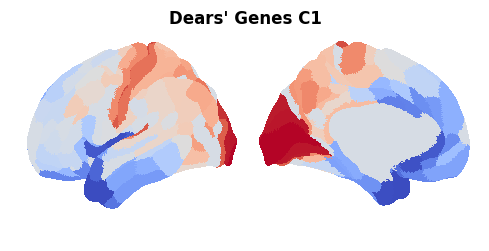

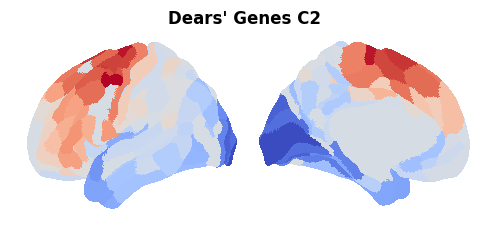

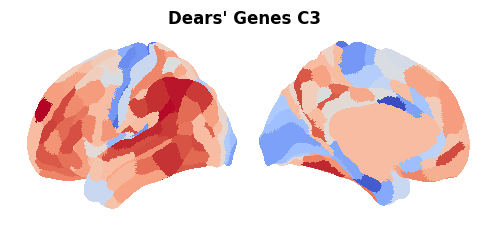

In [104]:
for name, cmap in zip(cnames, cmaps):
  plot_29k(cmap, center_min_max=0, title=name, colorbar=0) 

## Further cortical maps

In [105]:
## Helper function to get the HCP MMP regions
#!wget https://bitbucket.org/dpat/tools/raw/master/REF/ATLASES/HCP-MMP1_UniqueRegionList.csv -O data/misc/HCP-MMP1_UniqueRegionList.csv
def get_labels_hcp():
    """
    Get HCP atlas labels from source file and format for ggseg
    """
    hcp_info = (
        pd.read_csv('data/misc/HCP-MMP1_UniqueRegionList.csv')
        .rename(columns={'LR':'hemisphere', 'regionID':'id', 'region':'label'})
        .assign(structure='cortex')
        .assign(id=lambda x: [id-20 if id>180 else id for id in x['id']]) 
        # Aurina's HCP images code regions as 1-360, not 1-180,201-380
        # so recode to match the image files
    )
    labels_hcp = hcp_info.set_index('id')['label']
    return labels_hcp

#print(get_labels_hcp()[:180].to_list())

In [106]:
# load all the maps 
cm = pd.read_csv("data/misc/cortical_maps.csv")

# Get the list of corresponding regions for the loaded data
cmlabels = get_labels_hcp()[:180]

# Check if the parcel ordering corresponds
#cmlabels = ['V1', 'MST', 'V6', 'V2', 'V3', 'V4', 'V8', '4', '3b', 'FEF', 'PEF', '55b', 'V3A', 'RSC', 'POS2', 'V7', 'IPS1', 'FFC', 'V3B', 'LO1', 'LO2', 'PIT', 'MT', 'A1', 'PSL', 'SFL', 'PCV', 'STV', '7Pm', '7m', 'POS1', '23d', 'v23ab', 'd23ab', '31pv', '5m', '5mv', '23c', '5L', '24dd', '24dv', '7AL', 'SCEF', '6ma', '7Am', '7Pl', '7PC', 'LIPv', 'VIP', 'MIP', '1', '2', '3a', '6d', '6mp', '6v', 'p24pr', '33pr', 'a24pr', 'p32pr', 'a24', 'd32', '8BM', 'p32', '10r', '47m', '8Av', '8Ad', '9m', '8BL', '9p', '10d', '8C', '44', '45', '47l', 'a47r', '6r', 'IFJa', 'IFJp', 'IFSp', 'IFSa', 'p9-46v', '46', 'a9-46v', '9-46d', '9a', '10v', 'a10p', '10pp', '11l', '13l', 'OFC', '47s', 'LIPd', '6a', 'i6-8', 's6-8', '43', 'OP4', 'OP1', 'OP2-3', '52', 'RI', 'PFcm', 'PoI2', 'TA2', 'FOP4', 'MI', 'Pir', 'AVI', 'AAIC', 'FOP1', 'FOP3', 'FOP2', 'PFt', 'AIP', 'EC', 'PreS', 'H', 'ProS', 'PeEc', 'STGa', 'PBelt', 'A5', 'PHA1', 'PHA3', 'STSda', 'STSdp', 'STSvp', 'TGd', 'TE1a', 'TE1p', 'TE2a', 'TF', 'TE2p', 'PHT', 'PH', 'TPOJ1', 'TPOJ2', 'TPOJ3', 'DVT', 'PGp', 'IP2', 'IP1', 'IP0', 'PFop', 'PF', 'PFm', 'PGi', 'PGs', 'V6A', 'VMV1', 'VMV3', 'PHA2', 'V4t', 'FST', 'V3CD', 'LO3', 'VMV2', '31pd', '31a', 'VVC', '25', 's32', 'pOFC', 'PoI1', 'Ig', 'FOP5', 'p10p', 'p47r', 'TGv', 'MBelt', 'LBelt', 'A4', 'STSva', 'TE1m', 'PI', 'a32pr', 'p24'];
print(np.all(np.array([s.lower() for s in cmlabels]) == np.array(mmp_labels)))

# List all other maps that are to be included:
cmaps_df = cm.drop(['d_intramod60','hill_dev','dCT'], axis=1).apply(lambda x: (x-np.mean(x))/np.std(x)).set_index(get_labels_hcp()[:180])
cmaps_df.columns

True


Index(['paquola_FC', 'T1T2', 'MEG_theta', 'glasser_GI', 'dMT', 'hill_evo',
       'externopyramidisation', 'thickness', 'PC1_neurosynth', 'G1_fMRI',
       'allom', 'CBF'],
      dtype='object')

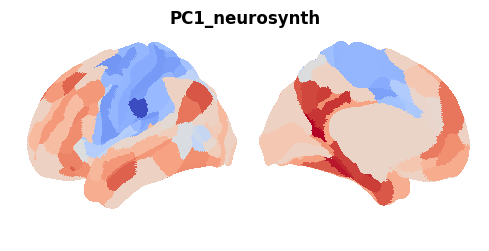

In [107]:
# Plot an example map
data29k = map_to_labels(cmaps_df["PC1_neurosynth"].to_numpy(), hcpmmpl, fill=0)
plot_29k(data29k, center_min_max=0, title="PC1_neurosynth", colorbar=0) 

In [108]:
for mapname in cmaps_df.columns:   
  data29k = map_to_labels(cmaps_df[mapname].to_numpy(), hcpmmpl, fill=0)
  cmaps.append(data29k)
  cnames.append(mapname)

In [109]:
print(cnames)
print(np.array(cmaps).shape)

["Dears' Genes C1", "Dears' Genes C2", "Dears' Genes C3", 'paquola_FC', 'T1T2', 'MEG_theta', 'glasser_GI', 'dMT', 'hill_evo', 'externopyramidisation', 'thickness', 'PC1_neurosynth', 'G1_fMRI', 'allom', 'CBF']
(15, 29696)


## Resting state gradients

In [110]:
# add gradients
from neuromaps.datasets import available_annotations, fetch_annotation
#for annotation in available_annotations(source=['margulies2016']):#(source=['abagen', 'margulies2016']):
#    print(annotation)
annotations = fetch_annotation(source=['margulies2016'])
print(sorted(annotations))

[('margulies2016', 'fcgradient01', 'fsLR', '32k'), ('margulies2016', 'fcgradient02', 'fsLR', '32k'), ('margulies2016', 'fcgradient03', 'fsLR', '32k'), ('margulies2016', 'fcgradient04', 'fsLR', '32k'), ('margulies2016', 'fcgradient05', 'fsLR', '32k'), ('margulies2016', 'fcgradient06', 'fsLR', '32k'), ('margulies2016', 'fcgradient07', 'fsLR', '32k'), ('margulies2016', 'fcgradient08', 'fsLR', '32k'), ('margulies2016', 'fcgradient09', 'fsLR', '32k'), ('margulies2016', 'fcgradient10', 'fsLR', '32k')]


In [111]:
import nibabel as nib
grayl=hcp.vertex_info['grayl'];
for a in annotations:
  data = nib.load(annotations[a][0]).darrays[0].data
  print(a[1], data[grayl].shape, end=", ")
  cmaps.append(data[grayl])
  cnames.append(a[1])  

fcgradient01 (29696,), fcgradient02 (29696,), fcgradient03 (29696,), fcgradient04 (29696,), fcgradient05 (29696,), fcgradient06 (29696,), fcgradient07 (29696,), fcgradient08 (29696,), fcgradient09 (29696,), fcgradient10 (29696,), 

In [112]:
np.array(cmaps).shape

(25, 29696)

## hansen receptor maps and xinhan cell types

In [9]:
# hansel receptor maps and xinhans cell type maps
yy = np.load("data/receptor_maps.L.fslr29k.npy", allow_pickle=1).item()
print(yy.keys())
receptor_maps = yy["maps"]
receptor_names = yy["receptor_names"]
print(receptor_maps.shape)

xx=np.load("data/celltype_maps.VisDfc18.L.fslr29k.npy", allow_pickle=1).item()
print(xx.keys())
cell_type_maps = xx["maps"]
cell_type_names = xx["celltype_names"]
print(cell_type_maps.shape)

dict_keys(['maps', 'celltype_names'])
(18, 29696)
dict_keys(['maps', 'receptor_names'])
(16, 29696)


In [114]:
refmaps = np.concatenate((ymaps, cmaps, cell_type_maps, receptor_maps), axis=0)
refnames = ynames +  cnames + cell_type_names + receptor_names
refmaps.shape, len(refnames)

((95, 29696), 95)

In [115]:
print(refnames)

['yeo7_Visual', 'yeo7_Somatomotor', 'yeo7_Dorsal Attention', 'yeo7_Ventral Attention', 'yeo7_Limbic', 'yeo7_Frontoparietal', 'yeo7_Default', 'yeo17_network_1', 'yeo17_network_2', 'yeo17_network_3', 'yeo17_network_4', 'yeo17_network_5', 'yeo17_network_6', 'yeo17_network_7', 'yeo17_network_8', 'yeo17_network_9', 'yeo17_network_10', 'yeo17_network_11', 'yeo17_network_12', 'yeo17_network_13', 'yeo17_network_14', 'yeo17_network_15', 'yeo17_network_16', 'yeo17_network_17', 'ca_Visual1', 'ca_Visual2', 'ca_Somatomotor', 'ca_Cingulo-Opercular', 'ca_Dorsal-attention', 'ca_Language', 'ca_Frontoparietal', 'ca_Auditory', 'ca_Default', 'ca_Posterior-Multimodal', 'ca_Ventral-Multimodal', 'ca_Orbito-Affective', "Dears' Genes C1", "Dears' Genes C2", "Dears' Genes C3", 'paquola_FC', 'T1T2', 'MEG_theta', 'glasser_GI', 'dMT', 'hill_evo', 'externopyramidisation', 'thickness', 'PC1_neurosynth', 'G1_fMRI', 'allom', 'CBF', 'fcgradient01', 'fcgradient02', 'fcgradient03', 'fcgradient04', 'fcgradient05', 'fcgrad

## >> Save all of the collected maps

In [116]:
np.save("data/all_cortical_reference_maps.fslr32k.l29.npy", dict(refmaps=refmaps, names = refnames))

# Annotate the PCA components

In [5]:
import numpy as np
import pickle as pk
import pandas as pd

# First load the coefficients of the RS-PCA model
coeffs = np.load("results/scores/rs_pca.lin_weights.200.spatial_zscore.yfull.npy")
print("Linear coefficients:", coeffs.shape)

# if instead the contribution values calculated above should be used:
#pl = np.load(""results/scores/rs_pca.lin_weight_onebyone_contrib.values.diff.spatial_zscore.yresid.npy", allow_pickle=1).item();
#best = pl["best"]; unique_contrasts = pl["unique_contrasts"]; contrast_ids_to_show=pl["contrast_ids_to_show"]; contr = pl["contr"]; 

# Load the corresponding group pca components (to which all indiviudal pca components had been aligned)
pca = pk.load(open("data/group_conmat_pca.200c.pkl",'rb')) 
print("Group PCA components:", pca.components_.shape)

# Load all the reference maps
p = np.load("data/all_cortical_reference_maps.fslr32k.l29.npy", allow_pickle=1).item()
refmaps= p["refmaps"]; refnames = p["names"];
print("Reference maps:", refmaps.shape, "\nE.g.", refnames[:5])

# Add information about the sources to the reference maps
source = ["Yeo7"]*7 + ["Yeo17"]*17 + ["CA"]*12 + ["DearGenes"]*3 +  ["Neuromaps"]*12 + ["fcgrads"]*10 + ["CellTypes"]*18 + ["Receptors"]*16;
ref_overview_df = pd.DataFrame(dict(source=source, map_name=refnames))
ref_overview_df.head(3)

Linear coefficients: (47, 200)
Group PCA components: (200, 29696)
Reference maps: (95, 29696) 
E.g. ['yeo7_Visual', 'yeo7_Somatomotor', 'yeo7_Dorsal Attention', 'yeo7_Ventral Attention', 'yeo7_Limbic']


,source,map_name
0,Yeo7,yeo7_Visual
1,Yeo7,yeo7_Somatomotor
2,Yeo7,yeo7_Dorsal Attention


In [6]:
# Correlate group compoentns with reference maps
corrs = np_pearson_cor(pca.components_.T, refmaps.T)
corrs.shape

(200, 95)

(200, 95) 0.9470105980313136 -0.6389842049279191


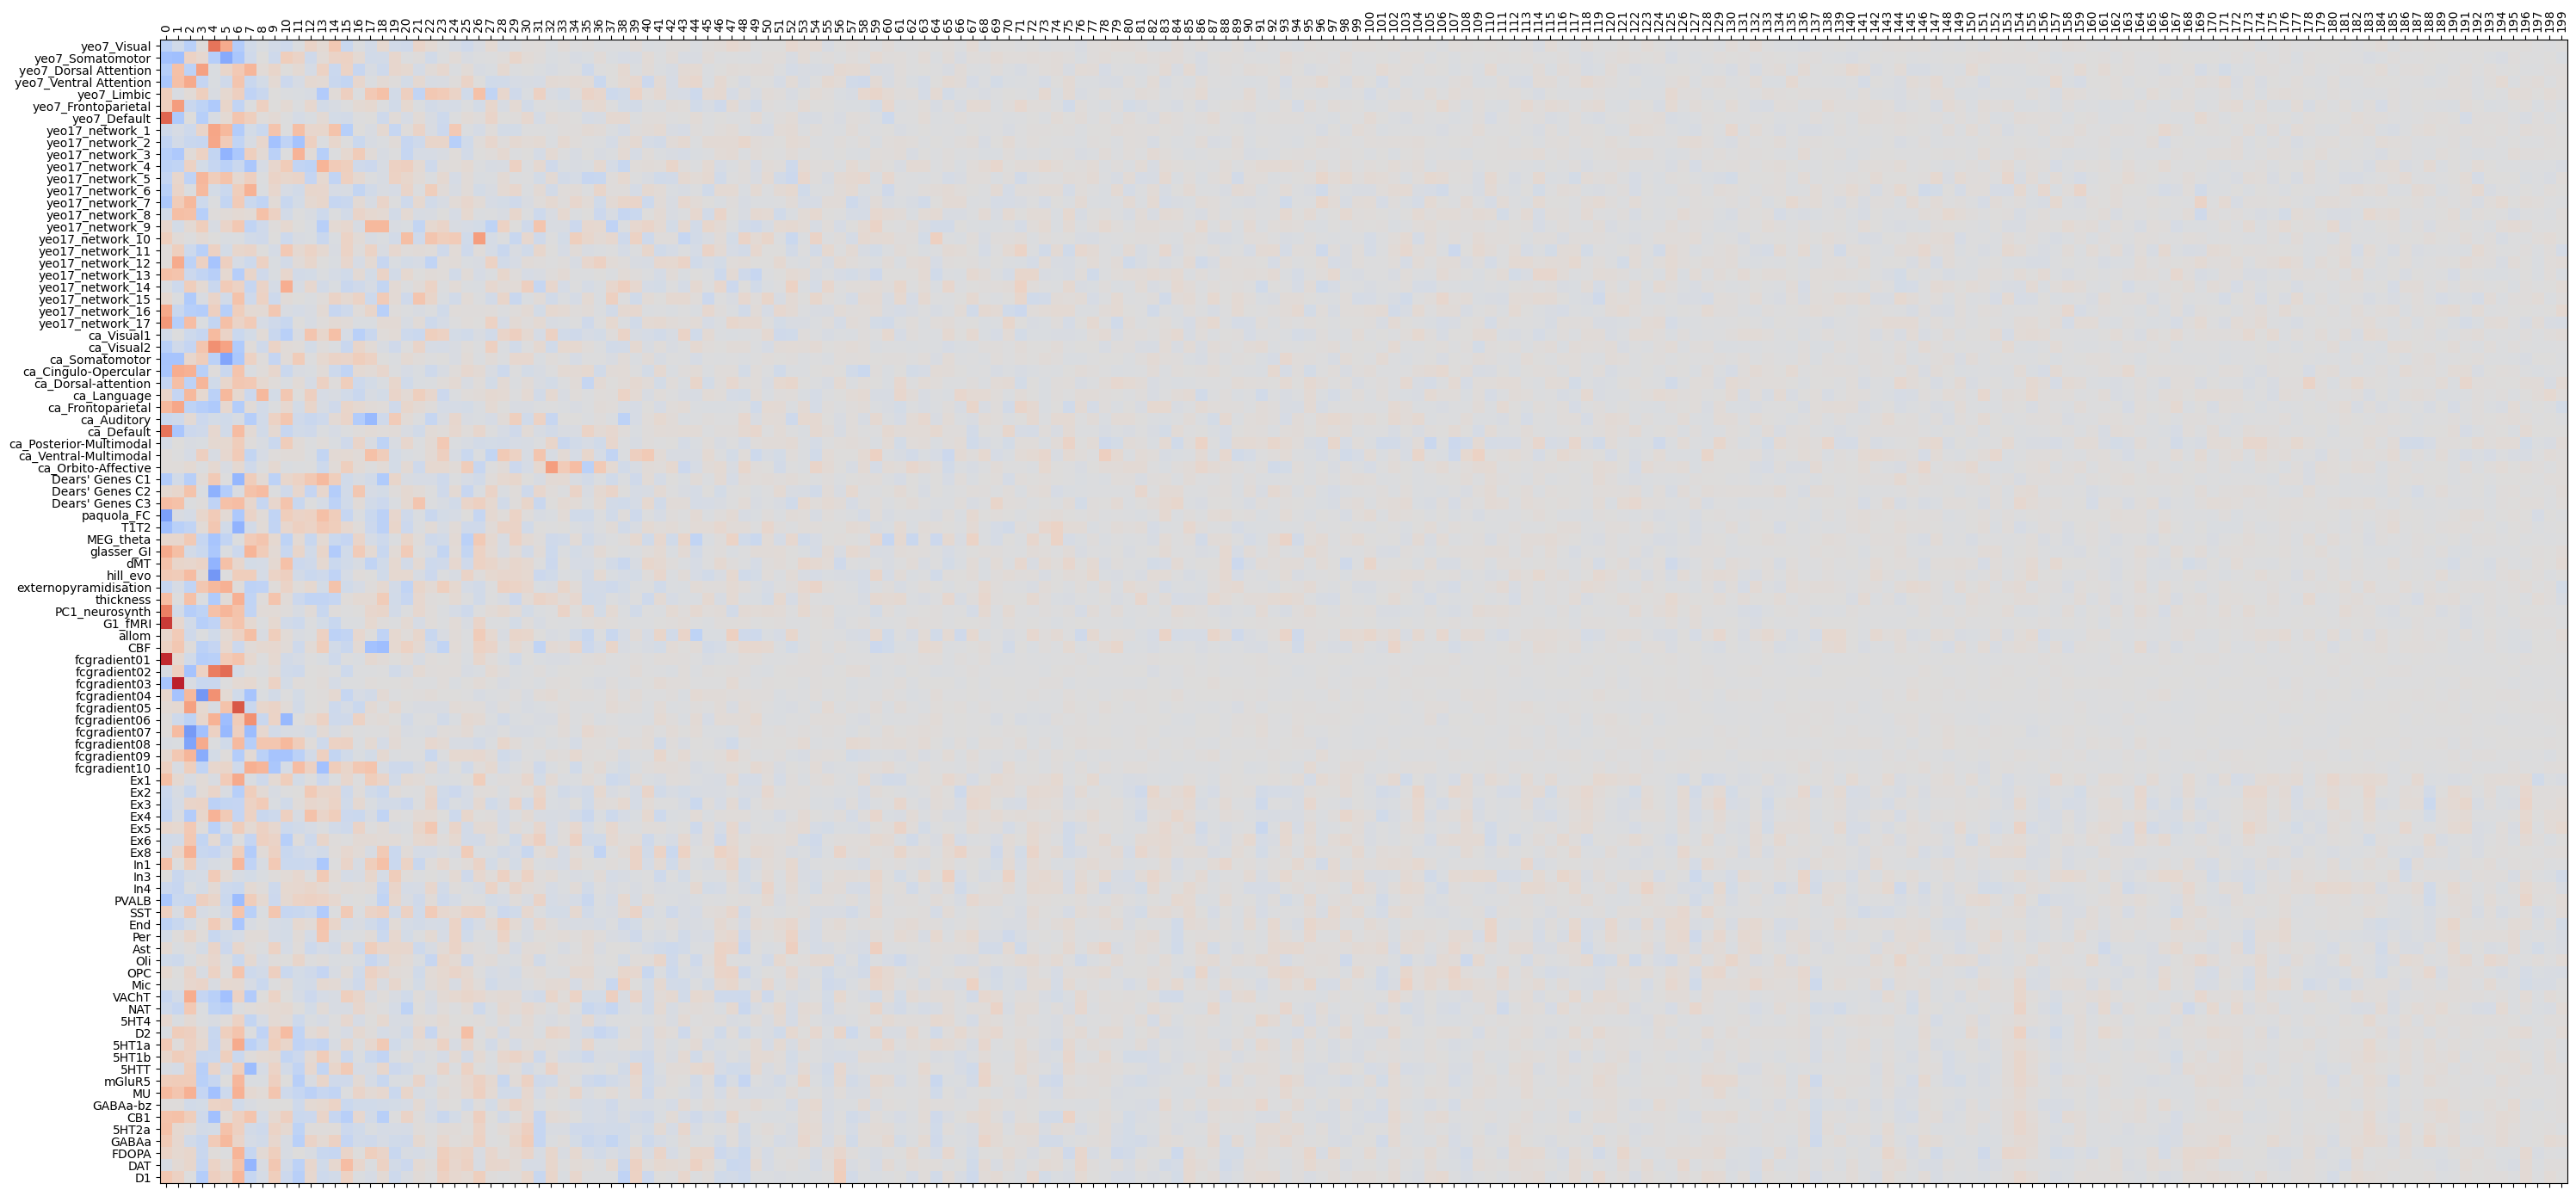

In [14]:
# Visuzalize the full correltations
print(corrs.shape, corrs.max(), corrs.min())
ax = plt.figure(figsize=(30,14)).gca()
ax.matshow(corrs.T, vmin=-1, vmax=1, cmap="coolwarm")
plt.yticks(np.arange(refmaps.shape[0]), refnames);
plt.xticks(np.arange(corrs.shape[0]), rotation=90);
plt.tight_layout()
plt.savefig("results/plots/rs_pca.component_correlation_with_refmaps.png");

## General component annotation (saved as xls)

In [151]:
# annotate the components with the best 10 reference maps
import pandas as pd
best_refer = np.argsort(np.absolute(corrs), axis=1)[:, ::-1]
table = []
for cn in range(len(corrs)):
  table.append([refnames[rn] + f" ({corrs[cn, rn].round(3)})" for rn in best_refer[cn,:10]])

df = pd.DataFrame(table, columns = [f"Reference Map #{n+1}" for n in range(10)])
df.index.name = "Group Comp Coefficients"
comp_to_ref =df;
df.head(3)

,Reference Map #1,Reference Map #2,Reference Map #3,Reference Map #4,Reference Map #5,Reference Map #6,Reference Map #7,Reference Map #8,Reference Map #9,Reference Map #10
Group Comp Coefficients,,,,,,,,,,
0,fcgradient01 (0.929),G1_fMRI (0.881),yeo7_Default (0.725),ca_Default (0.67),PC1_neurosynth (0.614),paquola_FC (-0.59),yeo17_network_17 (0.507),yeo17_network_16 (0.421),glasser_GI (0.407),T1T2 (-0.383)
1,fcgradient03 (0.947),yeo7_Frontoparietal (0.484),ca_Frontoparietal (0.428),yeo17_network_12 (0.405),ca_Cingulo-Opercular (0.391),yeo7_Somatomotor (-0.386),fcgradient04 (-0.355),ca_Somatomotor (-0.345),ca_Default (-0.33),yeo17_network_3 (-0.305)
2,fcgradient07 (-0.623),fcgradient08 (-0.564),fcgradient05 (0.456),yeo7_Ventral Attention (0.412),VAChT (0.395),Ex8 (0.375),ca_Cingulo-Opercular (0.371),MU (0.369),fcgradient02 (-0.355),fcgradient09 (0.338)


In [155]:
# annotate the reference maps with 10 best components 

import pandas as pd
best_comps = np.argsort(np.absolute(corrs), axis=0)[::-1]
table = []
for rn in range(corrs.shape[1]):
  row = [source[rn], refnames[rn]]
  row = row+[f"c{cn} ({corrs[cn, rn].round(3)})" for cn in best_comps[:10,rn]]
  table.append(row)

df = pd.DataFrame(table, columns = ["source", "refmap"]+[f"best_rs_comp_{n+1}" for n in range(10)])
ref_to_comp =df;


df.head(3)

,source,refmap,best_rs_comp_1,best_rs_comp_2,best_rs_comp_3,best_rs_comp_4,best_rs_comp_5,best_rs_comp_6,best_rs_comp_7,best_rs_comp_8,best_rs_comp_9,best_rs_comp_10
0,Yeo7,yeo7_Visual,c4 (0.664),c5 (0.406),c6 (-0.281),c2 (-0.241),c14 (0.214),c0 (-0.212),c15 (-0.141),c12 (0.111),c10 (-0.105),c21 (0.103)
1,Yeo7,yeo7_Somatomotor,c5 (-0.528),c1 (-0.386),c0 (-0.374),c6 (-0.326),c4 (-0.265),c10 (0.168),c2 (0.129),c15 (0.125),c11 (0.115),c14 (0.11)
2,Yeo7,yeo7_Dorsal Attention,c3 (0.455),c7 (0.336),c1 (0.271),c0 (-0.26),c2 (-0.211),c6 (0.207),c16 (-0.156),c13 (0.132),c14 (-0.128),c15 (0.12)


In [157]:
# best exclusive fiting 
sources = ref_overview_df["source"]
assignments = []
assignmat = np.zeros_like(corrs)

for nc, category in enumerate(sources.unique()):
  excl = np.where(sources!=category)[0]
  incl = np.where(sources==category)[0]
  cm = corrs.copy()
  cm[:,excl]=0;
  i=0;
  print(" " + category, end=": ");
  while i!=len(incl):
    print(i,end=",")
    c,m = np.unravel_index(np.absolute(cm).argmax(), cm.shape)
    #_, pv_spin = spintest(pca.components_[c], refmaps[m], v=False, spin_perm=sp)
    assignments.append([category, m, np.array(refnames)[m], c, cm[c,m]])#,pv_spin])
    cm[c,:]=0; cm[:,m]=0;
    assignmat[c,m]=nc+1;
    i=i+1;
    
df = pd.DataFrame(assignments, columns = ["source", "map#", "map_name", "comp#", "r"])#, "p"])
#plt.matshow(assignmat.T, cmap="tab20")
comp_to_ref_source_excl =df;

df

 Yeo7: 0,1,2,3,4,5,6, Yeo17: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16, CA: 0,1,2,3,4,5,6,7,8,9,10,11, DearGenes: 0,1,2, Neuromaps: 0,1,2,3,4,5,6,7,8,9,10,11, fcgrads: 0,1,2,3,4,5,6,7,8,9, CellTypes: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17, Receptors: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,

,source,map#,map_name,comp#,r
0,Yeo7,6,yeo7_Default,0,0.725183
1,Yeo7,0,yeo7_Visual,4,0.664092
2,Yeo7,1,yeo7_Somatomotor,5,-0.527809
3,Yeo7,5,yeo7_Frontoparietal,1,0.484173
4,Yeo7,2,yeo7_Dorsal Attention,3,0.455035
...,...,...,...,...,...
90,Receptors,84,5HT1b,18,-0.187128
91,Receptors,92,FDOPA,9,0.160176
92,Receptors,90,5HT2a,31,-0.157346
93,Receptors,88,GABAa-bz,14,0.122803


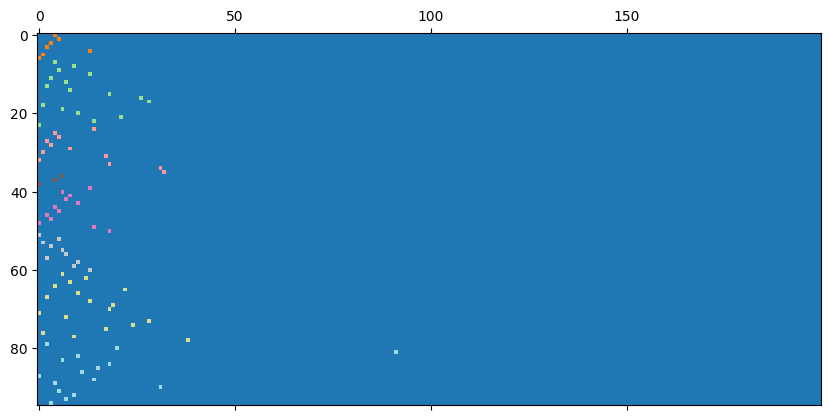

In [125]:
plt.matshow(assignmat.T, cmap="tab20")

In [153]:
# highest fitting reference map per category for each components

# annotate the components with the best 10 reference maps
import pandas as pd
best_refer = np.argsort(np.absolute(corrs), axis=1)[:, ::-1]
table = []
for cn in range(len(corrs)):
  row = []#[cn]
  for nc, category in enumerate(sources.unique()):
    incl = np.where(sources==category)[0]
    rn = np.argsort(np.absolute(corrs[cn,incl]))[::-1][0]
    row.append(np.array(refnames)[incl][rn] + f" ({corrs[cn,incl][rn].round(3)})")
  table.append(row)
               
df = pd.DataFrame(table, columns = sources.unique())
df.index.name = "RS-Component"
comp_to_ref_best_by_cat =df;
df.head(3)

,Yeo7,Yeo17,CA,DearGenes,Neuromaps,fcgrads,CellTypes,Receptors
RS-Component,,,,,,,,
0,yeo7_Default (0.725),yeo17_network_17 (0.507),ca_Default (0.67),Dears' Genes C3 (0.295),G1_fMRI (0.881),fcgradient01 (0.929),PVALB (-0.322),MU (0.31)
1,yeo7_Frontoparietal (0.484),yeo17_network_12 (0.405),ca_Frontoparietal (0.428),Dears' Genes C3 (0.268),glasser_GI (0.287),fcgradient03 (0.947),In4 (-0.149),CB1 (0.269)
2,yeo7_Ventral Attention (0.412),yeo17_network_7 (0.322),ca_Cingulo-Opercular (0.371),Dears' Genes C2 (0.255),hill_evo (0.299),fcgradient07 (-0.623),Ex8 (0.375),VAChT (0.395)


In [171]:
# Annotate best components by task

tnames_mid = ["Lang S-M", "WM2-0", "Motor Cue-Avg", "Emoti Face-Shape", "Social TOM-Rand", "Rel-Match", "Gamble Rew-Pun" ,"WM Face-Av", "Motor T-Avg"]

table = []
table_small = []

for tn in range(coeffs.shape[0]):
  best_coeff_ids = np.argsort(np.absolute(coeffs[tn,:]))[::-1];
  for cn in best_coeff_ids[:5]:
    row = [tn, unique_contrasts[tn], cn, coeffs[tn,cn]] + [refnames[rn] + f" ({corrs[cn, rn].round(3)})" for rn in best_refer[cn,:10]]
    table.append(row)
    if tn in cids: table_small.append(row)

header = ["cn", "contrast", "comp#", "coeff"] + [f"BestRef#{rn+1}" for rn in range(10)]
all_tasks_to_ref =pd.DataFrame(table, columns=header);
selected_tasks_to_ref =pd.DataFrame(table_small, columns=header);
selected_tasks_to_ref.head(4)

,cn,contrast,comp#,coeff,BestRef#1,BestRef#2,BestRef#3,BestRef#4,BestRef#5,BestRef#6,BestRef#7,BestRef#8,BestRef#9,BestRef#10
0,2,EMOTION_FACES-SHAPES,7,-0.223023,fcgradient06 (0.533),DAT (-0.454),fcgradient07 (-0.403),5HTT (-0.399),fcgradient10 (0.381),yeo17_network_6 (0.367),glasser_GI (0.345),fcgradient04 (-0.344),yeo7_Dorsal Attention (0.336),yeo17_network_4 (-0.324)
1,2,EMOTION_FACES-SHAPES,5,0.187855,fcgradient02 (0.699),ca_Somatomotor (-0.557),yeo7_Somatomotor (-0.528),yeo17_network_3 (-0.464),ca_Visual2 (0.452),fcgradient07 (-0.43),yeo7_Visual (0.406),fcgradient06 (-0.396),externopyramidisation (0.374),VAChT (-0.372)
2,2,EMOTION_FACES-SHAPES,11,0.125169,yeo17_network_2 (-0.356),yeo17_network_3 (0.353),fcgradient10 (0.293),yeo17_network_1 (0.283),D1 (-0.246),mGluR5 (-0.244),GABAa (-0.241),fcgradient09 (-0.232),DAT (-0.212),5HT2a (-0.207)
3,2,EMOTION_FACES-SHAPES,23,0.114760,ca_Posterior-Multimodal (0.206),yeo7_Limbic (0.192),CBF (-0.188),DAT (0.179),glasser_GI (-0.173),yeo17_network_10 (0.164),externopyramidisation (0.164),FDOPA (0.156),ca_Ventral-Multimodal (0.155),D1 (0.135)


In [173]:
# Save all to an multisheet xlsx
writer = pd.ExcelWriter("annotate_rs_components.xlsx", engine="xlsxwriter")

pd.DataFrame(corrs, columns = refnames).to_excel(writer, sheet_name="all_corrs")
comp_to_ref.to_excel(writer, sheet_name="comp_to_ref")
ref_to_comp.to_excel(writer, sheet_name="ref_to_comp")
comp_to_ref_source_excl.to_excel(writer, sheet_name="ref_to_comp (excl in source)") # (exclusive within category)
comp_to_ref_best_by_cat.to_excel(writer, sheet_name="comp_to_ref (best by source)")
all_tasks_to_ref.to_excel(writer, sheet_name="task_contr_to_ref")
selected_tasks_to_ref.to_excel(writer, sheet_name="sel_task_contr_to_ref")

writer.close()

## Task specific associations (along with spintests)


In [16]:
## Define a function for spintests

import numpy as np
from brainspace.datasets import load_gradient, load_marker, load_conte69
from scipy.stats import spearmanr
from brainspace.null_models import SpinPermutations

sphere_lh, sphere_rh = load_conte69(as_sphere=True)
sp = SpinPermutations(n_rep=1000, random_state=0)
sp.fit(sphere_lh)

def spintest(real_map, reference, hemi="left", grayl=hcp.vertex_info['grayl'], \
             spin_perm = None, v=0, n_rand=1000):
  if len(real_map) < 32492: 
    if v: print("restoring real map")
    real_map = hcp.left_cortex_data(real_map)
  if len(reference) < 32492: 
    if v: print("restoring reference")
    reference = hcp.left_cortex_data(reference)
  
  # make the medial wall NAN
  rm = np.zeros_like(real_map)
  rm[:]=np.nan#
  rm[grayl]=real_map[grayl]
  real_mask = ~np.isnan(rm)

  if spin_perm is None:
    spin_perm = SpinPermutations(n_rep=1000, random_state=0)
    spin_perm.fit(sphere_lh)
  
  real_rotated = np.vstack(spin_perm.randomize(rm))
  r_obs, pv_obs = spearmanr(rm[real_mask], real_map[real_mask])
  
  # Compute perm pval
  r_spin = np.empty(n_rand)
  for i, perm in enumerate(real_rotated):
    mask_rot = real_mask & ~np.isnan(perm)  # Remove midline
    r_spin[i] = spearmanr(perm[mask_rot], reference[mask_rot])[0]
    
  pv_spin = np.mean(np.abs(r_spin) >= np.abs(r_obs))
  if v: print(f'{fn.capitalize()}:\n Obs : {pv_obs:.5}\n Spin: {pv_spin:.5}\n')
  return pv_obs, pv_spin;

"""usage as:
t1wt2w_lh = load_marker('t1wt2w')[0]
embedding_lh = load_gradient('fc', idx=0, join=False)[0]
print(t1wt2w_lh.shape, embedding_lh.shape)

spintest(t1wt2w_lh, embedding_lh, v=1)

# its faster when we pre-init the spins
sp = SpinPermutations(n_rep=1000, random_state=0)
sp.fit(sphere_lh)
r_obs, pv_obs = spintest(t1wt2w_lh, embedding_lh, v=1, spin_perm=sp)
"""


"usage as:\nt1wt2w_lh = load_marker('t1wt2w')[0]\nembedding_lh = load_gradient('fc', idx=0, join=False)[0]\nprint(t1wt2w_lh.shape, embedding_lh.shape)\n\nspintest(t1wt2w_lh, embedding_lh, v=1)\n\n# its faster when we pre-init the spins\nsp = SpinPermutations(n_rep=1000, random_state=0)\nsp.fit(sphere_lh)\nr_obs, pv_obs = spintest(t1wt2w_lh, embedding_lh, v=1, spin_perm=sp)\n"

In [17]:
# Find the highest coefficients per task contrast
coeffs = np.load("results/scores/rs_pca.lin_weights.200.spatial_zscore.yfull.npy")
print(coeffs.shape)
best_coeffs = np.argsort(np.absolute(coeffs), axis=1)[:,::-1]
print("Best coefficients by task:", best_coeffs.shape)

# compute the best fitting reference for the most important components for each task contrast
for cn in contrast_ids_to_show:
  print(f"\n---{unique_contrasts[cn]}---")
  # for the four highest components for the given task contrast
  for comp_id in best_coeffs[cn,:4]: 
    # find the best references for the given component
    ref_ids = np.argsort(np.absolute(corrs[comp_id, :]))[::-1]
    ref_rvals = corrs[comp_id, ref_ids].round(3)
    print(f"# Component {comp_id}", end=": ")
    for i in range(4):
      _, pv_spin = spintest(pca.components_[comp_id], refmaps[ref_ids[i]], v=False, spin_perm=sp)
      print(f"{refnames[ref_ids[i]]} (r={ref_rvals[i]}, pv={pv_spin})", end=" | ")
    print("")

(47, 200)
Best coefficients by task: (47, 200)

---LANGUAGE_STORY-MATH---
# Component 1: fcgradient03 (r=0.947, pv=0.0) | yeo7_Frontoparietal (r=0.484, pv=0.0) | ca_Frontoparietal (r=0.428, pv=0.0) | yeo17_network_12 (r=0.405, pv=0.0) | 
# Component 6: fcgradient05 (r=0.78, pv=0.0) | T1T2 (r=-0.471, pv=0.0) | Dears' Genes C1 (r=-0.45, pv=0.0) | Ex1 (r=0.41, pv=0.0) | 
# Component 0: fcgradient01 (r=0.929, pv=0.0) | G1_fMRI (r=0.881, pv=0.0) | yeo7_Default (r=0.725, pv=0.0) | ca_Default (r=0.67, pv=0.0) | 
# Component 8: fcgradient10 (r=0.34, pv=0.0) | ca_Language (r=0.321, pv=0.0) | Dears' Genes C2 (r=0.3, pv=0.0) | yeo17_network_8 (r=0.272, pv=0.0) | 

---WM_2BK-0BK---
# Component 1: fcgradient03 (r=0.947, pv=0.0) | yeo7_Frontoparietal (r=0.484, pv=0.0) | ca_Frontoparietal (r=0.428, pv=0.0) | yeo17_network_12 (r=0.405, pv=0.0) | 
# Component 8: fcgradient10 (r=0.34, pv=0.0) | ca_Language (r=0.321, pv=0.0) | Dears' Genes C2 (r=0.3, pv=0.0) | yeo17_network_8 (r=0.272, pv=0.0) | 
# Compo

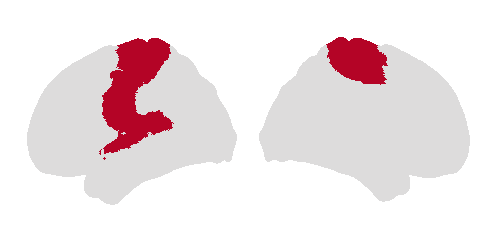

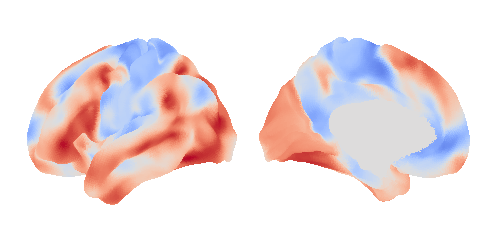

In [ ]:
idx=refnames.index("yeo7_Somatomotor")
plot_29k(refmaps[idx], colorbar=False)
plot_29k(pca.components_[5,:], colorbar=None)


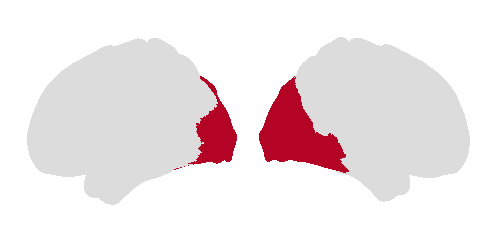

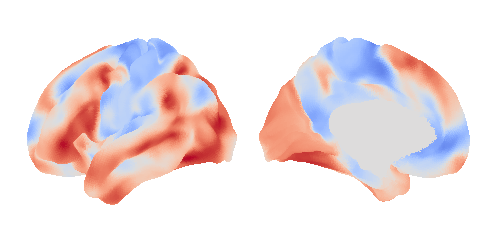

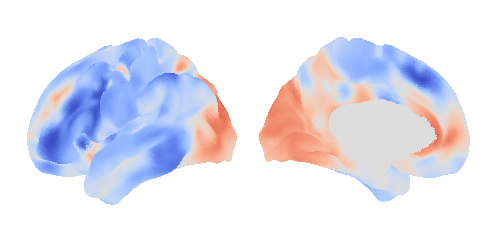

In [ ]:
idx=refnames.index("yeo7_Visual")
plot_29k(refmaps[0], colorbar=False)
plot_29k(pca.components_[5,:], colorbar=None)
plot_29k(pca.components_[4,:], colorbar=None)

# Spin test function in detail

In [151]:
import numpy as np
from brainspace.datasets import load_gradient, load_marker, load_conte69
from scipy.stats import spearmanr
from brainspace.null_models import SpinPermutations


sphere_lh, sphere_rh = load_conte69(as_sphere=True)

In [152]:
n_rand = 1000
sp = SpinPermutations(n_rep=n_rand, random_state=0)
sp.fit(sphere_lh, sphere_rh)
t1wt2w_rotated = np.vstack(sp.randomize(t1wt2w_lh, t1wt2w_rh))
t1wt2w_rotated.shape

NameError: name 't1wt2w_lh' is not defined

array([    0,     1,     2, ..., 32489, 32490, 32491])

In [47]:
myelin = np.zeros_like(t1wt2w_lh)
myelin[:]=np.nan#
grayl=hcp.vertex_info['grayl']
myelin[grayl]=t1wt2w_lh[grayl]
np.unique(myelin)

array([0.77874, 0.78225, 0.80766, ..., 2.3705 , 2.3709 ,     nan])

In [48]:
sp = SpinPermutations(n_rep=n_rand, random_state=0)
sp.fit(sphere_lh)
myelin_rotated = np.vstack(sp.randomize(myelin))
myelin_rotated.shape

(1000, 32492)

In [52]:
mask = ~np.isnan(myelin)
mask.sum(), len(grayl), (~np.isnan(myelin_rotated[10])).sum()

(29271, 29696, 29267)

In [22]:
from brainspace.datasets import load_gradient, load_marker, load_conte69
t1wt2w_lh, t1wt2w_rh = load_marker('t1wt2w')
t1wt2w = np.concatenate([t1wt2w_lh, t1wt2w_rh])

embedding = load_gradient('fc', idx=0, join=True)

mask = ~np.isnan(t1wt2w_lh)

print(t1wt2w_lh.shape, embedding.shape, mask.shape, mask.sum())

(32492,) (64984,) (32492,) 29271


In [23]:
embedding_lh = load_gradient('fc', idx=0, join=False)[0]
embedding_lh.shape

(32492,)

In [53]:
r_obs, pv_obs = spearmanr(t1wt2w_lh[mask], embedding_lh[mask])

# Compute perm pval
r_spin = np.empty(n_rand)
for i, perm in enumerate(myelin_rotated):
  mask_rot = mask & ~np.isnan(perm)  # Remove midline
  r_spin[i] = spearmanr(perm[mask_rot], embedding_lh[mask_rot])[0]

pv_spin = np.mean(np.abs(r_spin) >= np.abs(r_obs))
print(f'{fn.capitalize()}:\n Obs : {pv_obs:.5}\n Spin: {pv_spin:.5}\n')

/scratch/users/robert.scholz2/acc_dists/all_10_tasks_254_full_unrelated.yresid.npy:
 Obs : 0.0
 Spin: 0.001



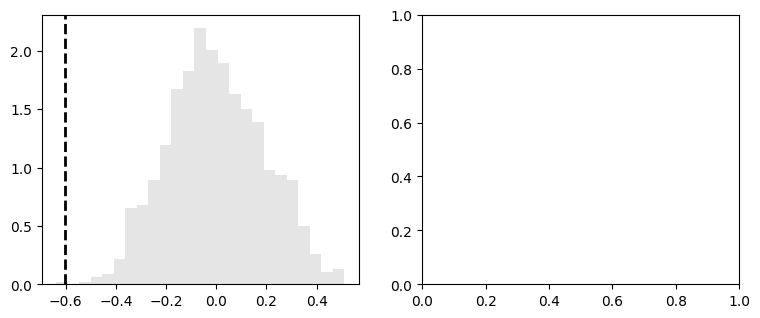

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3.5))
k=0;
axs[k].hist(r_spin, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
axs[k].axvline(r_obs, lw=2, ls='--', color='k')

In [ ]:
sp = SpinPermutations(n_rep=n_rand, random_state=0)

myelin_rotated = np.vstack(sp.randomize(myelin))
myelin_rotated.shape